In [82]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [116]:
def tile(ims, n, d):
    ims = np.reshape(ims, [*n, *d])
    combined = np.concatenate(np.concatenate(ims, axis=2), axis=0)
    return combined

def generate(z=0, d=2, b=2, n=20, o=(-1, -0.5), m=2, r=(100, 200)):
    canvas = np.zeros(r)
    for x, y in np.ndindex(canvas.shape):
        z_ = z
        c = (complex(y, x) / r[0] + complex(*o)) * m
        for i in range(n):
            z_ = z_ ** d + c
            if abs(z_) > b:
                canvas[x, y] += i
                break
    return canvas

(-0.5, 249.5, 249.5, -0.5)

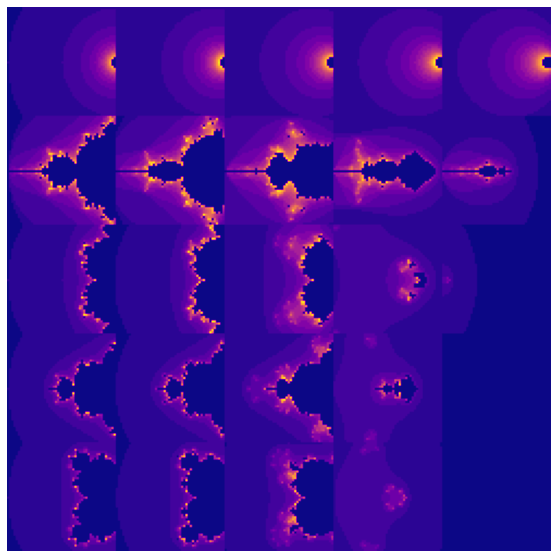

In [130]:
class FractalSet:
    def __init__(self, **kwargs):
        self.fractals = []
#         w = {a:b for (a, b) in kwargs.items() if type(b[0]) in [int, float]}
        w = {}
        self.fixed = {}
        for a, b in kwargs.items():
#             if type(b[0]) in [int, float]:
#             if len(b) == 3:
            if a not in 'r' and type(b) in [list, tuple]:
                if len(b) == 2:
                    b.append(kwargs['q'])
                w[a] = b
            elif a not in 'q':
                self.fixed[a] = b
        self.mdims = [b[-1] for a, b in w.items()]
        self.params = product(*[np.linspace(*b) for a, b in w.items()])
    
    def render(self):
        for p in self.params:
            self.fractals.append(generate(*p, **self.fixed))
        composite = tile(self.fractals, self.mdims, self.fixed['r'])
        return composite
    
    def __call__(self):
        return self.render()
    
# f = generate(r=(200, 400), b=1000, n=30)
f = FractalSet(z=[0, 1.5], d=[1, 5], r=[50, 50], q=5)()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
ax.imshow(f, cmap='plasma')
plt.axis('off')
# list or dict for params?

# TODO: multicolored fractals